# Coursework2: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

A PDF version of this notebook is also provided in case the figures do not render correctly.

**The deadline for submission is 19:00, Thu 14th February, 2019**

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution and max pooling operation. 

### YOUR TASK

- implement the forward pass for Conv2D and MaxPool2D
- You can only fill in the parts which are specified as "YOUR CODE HERE"
- You are **NOT** allowed to use the torch.nn module and the conv2d/maxpooling functions in torch.nn.functional

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Conv2D(nn.Module):
    
    def __init__(self, inchannel, outchannel, kernel_size, stride, padding, bias = True):
        
        super(Conv2D, self).__init__()
        
        self.inchannel = inchannel
        self.outchannel = outchannel
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        self.weights = nn.Parameter(torch.Tensor(outchannel, inchannel, 
                                                 kernel_size, kernel_size))
        self.weights.data.normal_(-0.1, 0.1)
        
        if bias:
            self.bias = nn.Parameter(torch.Tensor(outchannel, ))
            self.bias.data.normal_(-0.1, 0.1)
        else:
            self.bias = None
            
        
    def forward(self, x):
        
        ##############################################################
        #                       YOUR CODE HERE                       #       
        ##############################################################
    
        batch_size, in_channel, height, width = x.shape
        h_out = (height - self.kernel_size + 2 * self.padding) / self.stride + 1
        w_out = (width - self.kernel_size + 2 * self.padding) / self.stride + 1
        h_out = int(h_out)
        w_out = int(w_out)
        
        x_unfold = F.unfold(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        kernel = self.weights.view(self.outchannel, -1)
        output = kernel @ x_unfold
        output = output.view(batch_size, self.outchannel, h_out, w_out)
        
        if self.bias:
          output = torch.add(output, self.bias.unsqueeze(1).unsqueeze(1))

        ##############################################################
        #                       END OF YOUR CODE                     #
        ##############################################################
        

        return output
        

In [0]:
class MaxPool2D(nn.Module):
    
    def __init__(self, pooling_size):
        # assume pooling_size = kernel_size = stride
        
        super(MaxPool2D, self).__init__()
        
        self.pooling_size = pooling_size
        

    def forward(self, x):
        
        
        ##############################################################
        #                       YOUR CODE HERE                       #       
        ##############################################################

        batch_size, in_channel, height, width = x.shape
        h_out = 1 + (height - self.pooling_size) / self.pooling_size
        w_out = 1 + (width - self.pooling_size) / self.pooling_size
        h_out = int(h_out)
        w_out = int(w_out)
        output = torch.zeros(batch_size, in_channel, h_out, w_out)

        x_unfold = x.unfold(2, self.pooling_size, self.pooling_size).unfold(3, self.pooling_size, self.pooling_size)
        output = x_unfold.contiguous().view(x_unfold.size()[:4] + (-1,)).max(dim=-1)[0]

        ##############################################################
        #                       END OF YOUR CODE                     #
        ##############################################################
                
        
        return output
        

In [0]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2D(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2D(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2D(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


In [0]:
# define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2D(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2D(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

In [ ]:
Great.

## Part 2 (40 points)

In this part, you will train the ResNet-18 defined in the previous part on the CIFAR-10 dataset. Code for loading the dataset, training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimiser

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

**YOUR ANSWER FOR 2.4 HERE**

A: Given the large number of trainable parameters and data, it would be extremely expensive to use grid searching to search for hyperparameter. Hence the beest strategy is to use Bayesian Optimization for hyperparameter searching. This strategy builds a model which predict the values for the hyperparameters configuratoin. At each new iteration, the model will become more confident of the hyperparemeters that could lead to a better accuracy for the network.


In [ ]:
Good answer.

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T


transform = T.ToTensor()


# load data

NUM_TRAIN = 49000
print_every = 100


data_dir = './data'
cifar10_train = dset.CIFAR10(data_dir, train=True, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10(data_dir, train=True, download=True, transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)


USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc


def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                #check_accuracy(loader_val, model)
                print()

GPyOpt is a tool for optimization of black-box functions using Gaussian processes, implemented by the group of Machine Learning of the University of Sheffield, based on GPy.

It can be used to search for the most optimal hyper-parameter for the Adam optimizer.

In [0]:
!pip install GPy GPyOpt

import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

# Use GPyOpt for hyper-parameter search
domain = [{'name': 'lr', 'type': 'continuous', 'domain': (0.005, 0.02)},
          {'name': 'weight_decay', 'type': 'continuous', 'domain': (0., 0.001)}
         ]

model = ResNet18()

def hyperparameter_search(param):
  param = param[0]
  optimizer = optim.Adam(model.parameters(), lr=param[0], weight_decay=param[1])
  train_part(model, optimizer, epochs=10)
  # The check_accuracy function is modified such that it returns the acc
  return check_accuracy(loader_test, model)

bayesian_opt = BayesianOptimization(f=hyperparameter_search,
                                    domain=domain,
                                    model_type='GP',
                                    acquisition_type='LCB',
                                    acquisition_weight=0.1)

bayesian_opt.run_optimization(max_iter=20)

I could not get GPy to find the best hypermeter as Colab keeps timeout in the middle of the optimization. I tried to train using less epochs and number of iterations but it seems to perform more poorly compared to that of the default hyper-parameter and due to time constraint, I decided to use the default hyper-parameter

In [0]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

# Normalize the training data
mean = 0.
std = 0.
number_train = 0
for (x, y) in loader_train:
  batch_size = x.size(0)
  img = x.view(batch_size, x.size(1), -1)
  mean += img.mean(2).sum(0)
  std += img.std(2).sum(0)
  number_train += batch_size
mean /= number_train
std /= number_train

transform = T.Compose([T.ToTensor(), T.Normalize(mean=mean, std=std)])

loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

##############################################################
#                       END OF YOUR CODE                     #
##############################################################


# define and train the network
model = ResNet18()
optimizer = optim.Adam(model.parameters())

train_part(model, optimizer, epochs = 10)


# report test set accuracy

check_accuracy(loader_test, model)

# save the model
torch.save(model.state_dict(), 'model.pt')

766
Epoch: 0, Iteration 0, loss = 2.4820

Epoch: 0, Iteration 100, loss = 2.2080

Epoch: 0, Iteration 200, loss = 2.1397

Epoch: 0, Iteration 300, loss = 2.1671

Epoch: 0, Iteration 400, loss = 1.9556

Epoch: 0, Iteration 500, loss = 2.0719

Epoch: 0, Iteration 600, loss = 2.0877

Epoch: 0, Iteration 700, loss = 1.7994

766
Epoch: 1, Iteration 0, loss = 1.9521

Epoch: 1, Iteration 100, loss = 1.8942

Epoch: 1, Iteration 200, loss = 1.8444

Epoch: 1, Iteration 300, loss = 1.7076

Epoch: 1, Iteration 400, loss = 1.9128

Epoch: 1, Iteration 500, loss = 1.7276

Epoch: 1, Iteration 600, loss = 1.9717

Epoch: 1, Iteration 700, loss = 1.5953

766
Epoch: 2, Iteration 0, loss = 1.7199

Epoch: 2, Iteration 100, loss = 1.3420

Epoch: 2, Iteration 200, loss = 1.6851

Epoch: 2, Iteration 300, loss = 1.4010

Epoch: 2, Iteration 400, loss = 1.3782

Epoch: 2, Iteration 500, loss = 1.4417

Epoch: 2, Iteration 600, loss = 1.5166

Epoch: 2, Iteration 700, loss = 1.3961

766
Epoch: 3, Iteration 0, loss = 

In [ ]:
Performance could be better - well done for using Bayesian optimisation for hyperparameter tuning.

In [0]:
## Part 3 (20 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**

A:

1. We can observed that at each feature maps, the layer maps to a certain feature of the images. As the size of the images is very small, pooling would cause the feaure maps at high-level layers to be very small, making inspection impossible.

2. Based on the training log, the training of the network seems to be working sufficiently good as the loss decreases each epoch. However the test set accuracy is at 71% which definitely could be improved. This can be improved with hyper-parameter search tuning using Bayesian optimisation as explained above. Beside that , a larger training dataset might also be able to improve the performance.

3. One other possible way to analyse the performance of the network is to measure the precision and recall of the network predictions. Precision and recall are measured using the number of true positives, false positives and false negatives, where

```
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
```

In [ ]:
1) It is not so much about the size of the feature maps as it is about low level maps usually representing edges/corners whereas high level ones being more abstract.
2) A larger dataset always helps - but in this case we have a specific dataset - so, data augmentation?
3)Sure - but also checking for overfitting by plotting train vs validation error.

<Figure size 576x396 with 0 Axes>

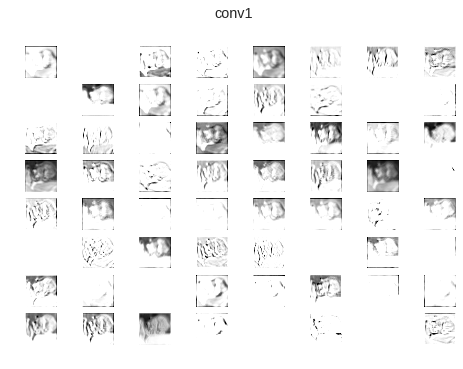

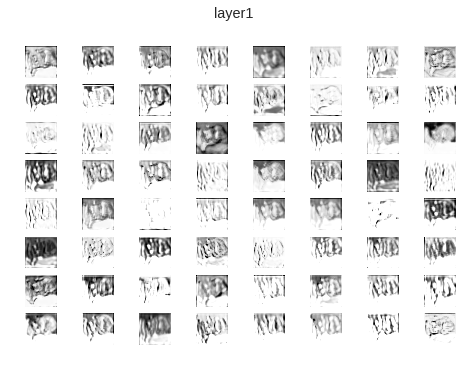

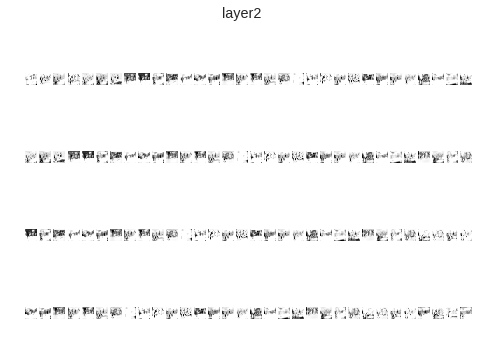

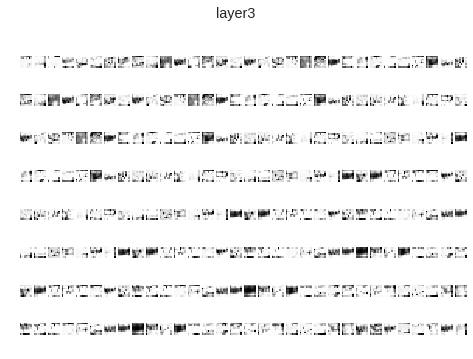

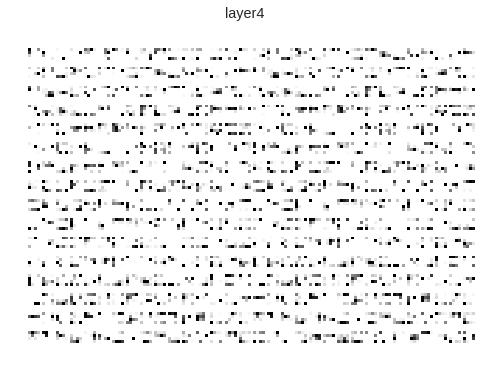

In [17]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')

In [ ]:
Good work - 86/100

**=============== END OF CW2 ===============**